In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)


In [2]:
import yfinance as yf

# Define the ticker symbol for S&P 500 (SPY is an ETF that tracks the S&P 500)
ticker_symbol = "AMZN"

# Set the start and end dates for the data
start_date = "2020-01-10"  # Replace with your desired start date
end_date = "2024-01-10"    # Replace with your desired end date

# start_date = "2019-08-01"  # Replace with your desired start date
# end_date = "2023-08-01"  


# Use yfinance to download the data
amazon_stock = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the data
amazon_stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-10,95.268501,95.347000,94.000000,94.157997,94.157997,57074000
2020-01-13,94.565498,94.900002,94.040001,94.565002,94.565002,55616000
2020-01-14,94.293999,94.355499,92.927498,93.472000,93.472000,68818000
2020-01-15,93.612503,93.943001,92.754501,93.100998,93.100998,57932000
2020-01-16,94.149498,94.279503,93.301003,93.897003,93.897003,53190000


In [3]:
import pandas as pd

amazon_stock.index = pd.to_datetime(amazon_stock.index)

# Reset the index to make "Date" a regular column
amazon_stock.reset_index(drop=False, inplace=True)

In [5]:
df_close = amazon_stock[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

# decomp = seasonal_decompose(df_close, period=365)
# fig = decomp.plot()
# fig.set_size_inches(20, 8)

,Close
Date,
2020-01-10,94.157997
2020-01-13,94.565002
2020-01-14,93.472000
2020-01-15,93.100998
2020-01-16,93.897003


In [6]:
import pandas_ta as ta


# Creating technical indicators
amazon_stock['EMA_9'] = ta.ema(amazon_stock['Close'], length=9, fillna=True).shift()
amazon_stock['SMA_5'] = ta.sma(amazon_stock['Close'], length=5, fillna=True).shift()
amazon_stock['SMA_10'] = ta.sma(amazon_stock['Close'], length=10, fillna=True).shift()
amazon_stock['SMA_15'] = ta.sma(amazon_stock['Close'], length=15, fillna=True).shift()
amazon_stock['SMA_30'] = ta.sma(amazon_stock['Close'], length=30, fillna=True).shift()

amazon_stock['Target'] = amazon_stock['Close']-amazon_stock.Open
amazon_stock['Target'] = amazon_stock['Target'].shift(-1)
amazon_stock['TargetClass'] = [1 if amazon_stock.Target[i]>0 else 0 for i in range(len(amazon_stock))]
amazon_stock['TargetNextClose'] = amazon_stock['Close'].shift(-1)



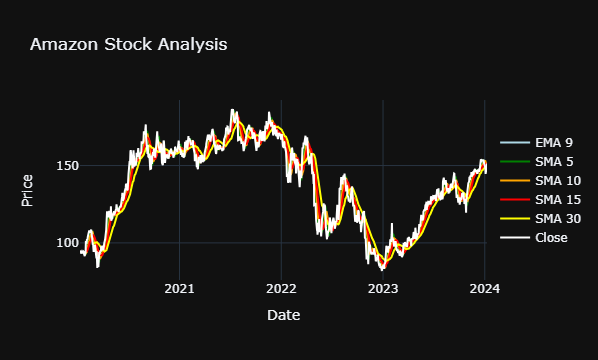

In [7]:
# Create a Plotly figure
fig = go.Figure()

# Add traces for moving averages
fig.add_trace(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['EMA_9'], mode='lines', name='EMA 9', line=dict(color='lightblue')))
fig.add_trace(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['SMA_5'], mode='lines', name='SMA 5', line=dict(color='green')))
fig.add_trace(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['SMA_10'], mode='lines', name='SMA 10', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['SMA_15'], mode='lines', name='SMA 15', line=dict(color='red')))
fig.add_trace(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['SMA_30'], mode='lines', name='SMA 30', line=dict(color='yellow')))

# Add trace for the close price
fig.add_trace(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['Close'], mode='lines', name='Close', line=dict(color='white')))

# Customize layout
fig.update_layout(
    title='Amazon Stock Analysis',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',  # Choose a light theme
    legend=dict(x=1.02, y=0.5),  # Adjust the legend position
)

# Show the figure
fig.show()

In [8]:
# Creating function for RSI
def relative_strength_idx(df, n=14):
    close = amazon_stock['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

amazon_stock['RSI'] = relative_strength_idx(amazon_stock).fillna(0)


In [1]:
# Creating a Plotly figure for RSI
fig_rsi = go.Figure()

# Add trace for RSI
fig_rsi.add_trace(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['RSI'], mode='lines', name='RSI', line=dict(color='white')))


NameError: name 'go' is not defined

In [10]:
# Creating MACD and MACD signal
EMA_12 = pd.Series(amazon_stock['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(amazon_stock['Close'].ewm(span=26, min_periods=26).mean())
amazon_stock['MACD'] = pd.Series(EMA_12 - EMA_26)
amazon_stock['MACD_signal'] = pd.Series(amazon_stock.MACD.ewm(span=9, min_periods=9).mean())



In [12]:
# Shifting tomorrow's price to predict on it
amazon_stock['close_tmr'] = amazon_stock['Close'].shift(-1)
amazon_stock['close_today'] = amazon_stock['Close']

In [13]:
# Calculating OBV and ROC
amazon_stock['OBV'] = (amazon_stock['Volume'] * ((amazon_stock['close_today'] - amazon_stock['close_today'].shift(1)) > 0)).cumsum()
amazon_stock['ROC'] = amazon_stock['Close'].pct_change() * 100  # Calculate percentage change


In [15]:
amazon_stock = amazon_stock.iloc[33:] # Because of moving averages and MACD line
amazon_stock = amazon_stock[:-1]      # Because of shifting close price

amazon_stock.index = range(len(amazon_stock))

In [17]:
# Using 
amazon_stock['Year'] = amazon_stock['Date'].dt.year
amazon_stock['Month'] = amazon_stock['Date'].dt.month
amazon_stock['Day'] = amazon_stock['Date'].dt.day

In [23]:
# Convert pandas_ta columns to numeric (currently objects not recognized by xgbregressor)
cols_to_convert = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30']
amazon_stock[cols_to_convert] = amazon_stock[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [24]:
test_size  = 0.20

test_split_idx  = int(amazon_stock.shape[0] * (1-test_size))

train_df = amazon_stock.loc[:test_split_idx].copy()
test_df = amazon_stock.loc[test_split_idx+1:].copy()
train_df = train_df.sort_values(by='Date')
test_df = test_df.sort_values(by='Date')


In [27]:
drop_cols = ['Open', 'High', 'Low','Date', 'Adj Close', 'Volume', 'Close',  'TargetNextClose', 'TargetClass', 'Target', 'ROC', 'OBV']  # Date,  Close, Volume, OpenInt

# Assuming train_df, valid_df, and test_df are your DataFrames
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

In [28]:
# Making copies
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame with the features you want to scale
columns_to_scale = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal', 'close_today']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the selected columns and transform the data
train_df_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df_scaled[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

Labels and features

In [30]:
y_train = train_df['close_tmr'].copy()
X_train = train_df.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

y_train_scaled = train_df_scaled['close_tmr'].copy()
X_train_scaled = train_df_scaled.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

y_test  = test_df['close_tmr'].copy()
X_test  = test_df.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

y_test_scaled  = test_df_scaled['close_tmr'].copy()
X_test_scaled  = test_df_scaled.drop(['close_tmr'], axis=1)  # Drop both 'Close' and 'Adj Close'

X_train.isna().sum()

EMA_9          0
SMA_5          0
SMA_10         0
SMA_15         0
SMA_30         0
RSI            0
MACD           0
MACD_signal    0
close_today    0
Year           0
Month          0
Day            0
dtype: int64

In [31]:
X_train.dtypes

EMA_9          float64
SMA_5          float64
SMA_10         float64
SMA_15         float64
SMA_30         float64
RSI            float64
MACD           float64
MACD_signal    float64
close_today    float64
Year             int32
Month            int32
Day              int32
dtype: object

In [32]:
# Convert pandas_ta columns to numeric (currently objects not recognized by xgbregressor)
cols_to_convert = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30']
amazon_stock[cols_to_convert] = amazon_stock[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [33]:
# from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Parameters after gridsearch
gamma_val = 0.01
learning_rate_val = 0.01
max_depth_val = 5
n_estimators_val = 300
random_state_val = 42

# XGBRegressor
xgb_reg = XGBRegressor(
    gamma=gamma_val,
    learning_rate=learning_rate_val,
    max_depth=max_depth_val,
    n_estimators=n_estimators_val,
    random_state=random_state_val
)

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [34]:
import numpy as np
# Making predictions on the test set
y_test_pred = xgb_reg.predict(X_test)

# Evaluating the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f'Test RMSE: {rmse_test}')

Test RMSE: 3.347708471847791


In [35]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Calculate MAPE on the test set
mape_test = calculate_mape(y_test, y_test_pred)
print(f'Test MAPE: {mape_test:.2f}%')

Test MAPE: 2.06%


In [36]:
import numpy as np
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_test_pred[:5]}')

y_true = [102.41000366 103.94999695 101.09999847 102.05999756 102.16999817]
y_pred = [106.01572  104.71436  107.60091  102.368065 102.368065]


In [37]:
# Predict tomorrow's price for the last point in the test set
last_point_features = X_test.iloc[-1, :]  # Assuming the last row in X_test
last_point_prediction = xgb_reg.predict(last_point_features.values.reshape(1, -1))

print(f"Predicted price for tomorrow: {last_point_prediction[0]}")

Predicted price for tomorrow: 147.07476806640625


In [38]:
df = pd.DataFrame({'y_true': y_test, 'y_pred': y_test_pred})


In [46]:
from sklearn.metrics import accuracy_score, classification_report

k = 7 # Set the number of days to predict ahead

# Convert regression predictions to binary labels (1 for price up, 0 for price down)
predicted_direction = np.where(y_test_pred[k:] > y_test_pred[:-k], 1, 0)

# Create true binary labels based on the actual price movements
true_direction = np.where(y_test.values[k:] > y_test.values[:-k], 1, 0)


# Calculate accuracy and other classification metrics
accuracy = accuracy_score(true_direction, predicted_direction)
classification_report_result = classification_report(true_direction, predicted_direction)

# NOTES: 3rd class - neutral
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)

Accuracy: 0.786096256684492
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.81      0.70        58
           1       0.90      0.78      0.83       129

    accuracy                           0.79       187
   macro avg       0.76      0.79      0.77       187
weighted avg       0.81      0.79      0.79       187



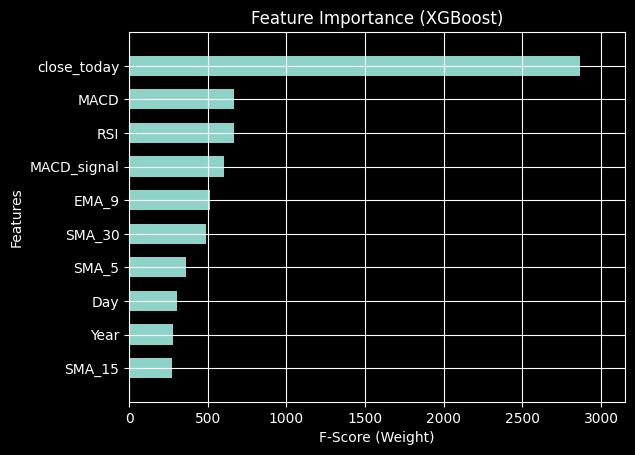

In [50]:
import xgboost as xgb
import matplotlib.pyplot as plt


# Feature importance
xgb.plot_importance(xgb_reg, importance_type='weight', max_num_features=10, height=0.6, show_values=False, title='Feature Importance (XGBoost)')
plt.xlabel('F-Score (Weight)')
plt.ylabel('Features')
plt.show()

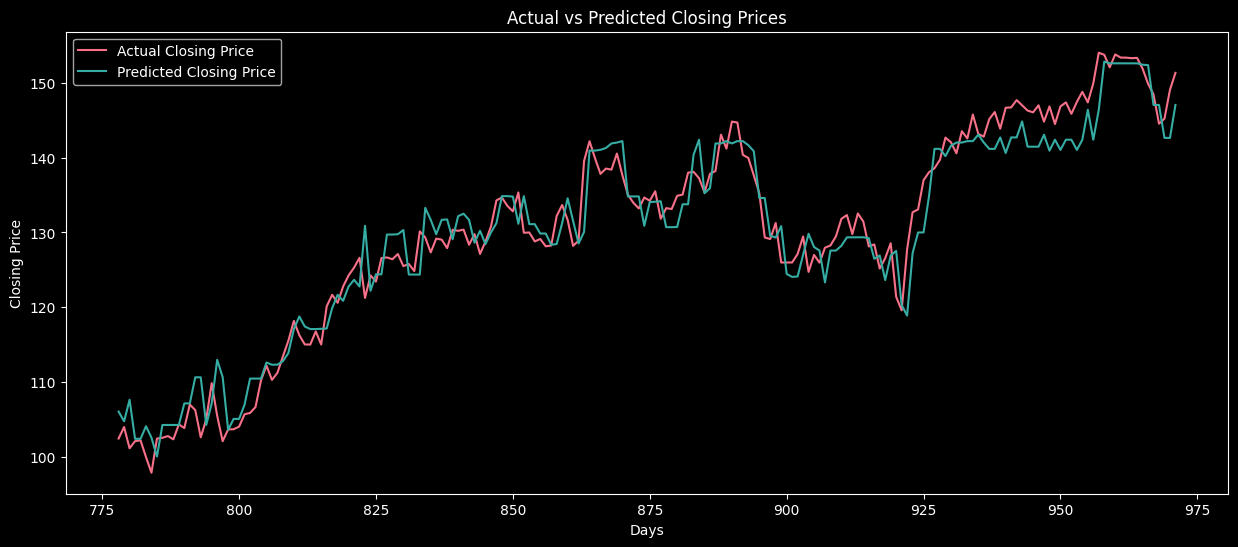

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a dark background using Matplotlib
plt.style.use('dark_background')

# Set a custom color palette for a cool and professional look
colors = sns.color_palette("husl", 2)

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot actual closing prices
sns.lineplot(x=y_test.index, y=y_test.values, label='Actual Closing Price', color=colors[0])

# Plot predicted closing prices
sns.lineplot(x=y_test.index, y=y_test_pred, label='Predicted Closing Price', color=colors[1])

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()